In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("cfilt/iitb-english-hindi")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1659083 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2507 [00:00<?, ? examples/s]

In [ ]:
source_train_file = open("source_train.txt", "w+", encoding='utf8')
target_train_file = open("target_train.txt", "w+", encoding='utf8')
for translation_pair in dataset["train"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  source_train_file.write(source_sentence.strip("\n") + "\n")
  target_train_file.write(target_sentence.strip("\n") + "\n")
source_train_file.close()
target_train_file.close()

source_valid_file = open("source_valid.txt", "w+", encoding='utf8')
target_valid_file = open("target_valid.txt", "w+", encoding='utf8')
for translation_pair in dataset["validation"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  source_valid_file.write(source_sentence.strip("\n") + "\n")
  target_valid_file.write(target_sentence.strip("\n") + "\n")
source_valid_file.close()
target_valid_file.close()

source_test_file = open("source_test.txt", "w+", encoding='utf8')
target_test_file = open("target_test.txt", "w+", encoding='utf8')
for translation_pair in dataset["test"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  source_test_file.write(source_sentence.strip("\n") + "\n")
  target_test_file.write(target_sentence.strip("\n") + "\n")
source_test_file.close()
target_test_file.close()

In [ ]:
! pip install subword-nmt

In [ ]:
import os
os.environ['NUM_OF_MERGE_OPERATIONS'] = "16000"


In [ ]:
! cat source_train.txt source_test.txt source_valid.txt > source_full.txt

In [ ]:
! cat target_train.txt target_test.txt target_valid.txt > target_full.txt

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy



In [ ]:
# Load source and target text files in chunks
def load_text_file(file_path, max_lines=None):
    lines = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            lines.append(line.strip())
    return lines

def load_text_files_chunked(file_paths, max_lines=None):
    lines = []
    for file_path in file_paths:
        lines.extend(load_text_file(file_path, max_lines))
    return lines

source_train_files = ["source_train.txt"]
target_train_files = ["target_train.txt"]
source_valid_files = ["source_valid.txt"]
target_valid_files = ["target_valid.txt"]
source_test_files = ["source_test.txt"]
target_test_files = ["target_test.txt"]

source_train = load_text_files_chunked(source_train_files, max_lines=10000)  # Limiting the number of lines for reduced memory usage
target_train = load_text_files_chunked(target_train_files, max_lines=10000)
source_valid = load_text_files_chunked(source_valid_files, max_lines=1000)   # Similarly, limit validation and test data
target_valid = load_text_files_chunked(target_valid_files, max_lines=1000)
source_test = load_text_files_chunked(source_test_files, max_lines=1000)
target_test = load_text_files_chunked(target_test_files, max_lines=1000)

# Tokenize text data
def tokenize_text(texts, tokenizer=None):
    if tokenizer is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
        tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences, tokenizer

source_train_seqs, source_tokenizer = tokenize_text(source_train)
source_valid_seqs, _ = tokenize_text(source_valid, source_tokenizer)
source_test_seqs, _ = tokenize_text(source_test, source_tokenizer)

target_train_seqs, target_tokenizer = tokenize_text(target_train)
target_valid_seqs, _ = tokenize_text(target_valid, target_tokenizer)
target_test_seqs, _ = tokenize_text(target_test, target_tokenizer)

# Limit sequence lengths
max_seq_length = 50
source_train_seqs = tf.keras.preprocessing.sequence.pad_sequences(source_train_seqs, maxlen=max_seq_length, padding='post')
source_valid_seqs = tf.keras.preprocessing.sequence.pad_sequences(source_valid_seqs, maxlen=max_seq_length, padding='post')
source_test_seqs = tf.keras.preprocessing.sequence.pad_sequences(source_test_seqs, maxlen=max_seq_length, padding='post')
target_train_seqs = tf.keras.preprocessing.sequence.pad_sequences(target_train_seqs, maxlen=max_seq_length, padding='post')
target_valid_seqs = tf.keras.preprocessing.sequence.pad_sequences(target_valid_seqs, maxlen=max_seq_length, padding='post')
target_test_seqs = tf.keras.preprocessing.sequence.pad_sequences(target_test_seqs, maxlen=max_seq_length, padding='post')

# Define model parameters
source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1
embedding_dim = 128
hidden_units = 256
num_layers = 1
dropout_rate = 0.1
batch_size = 32  # Decrease batch size
num_epochs = 10

# Define encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=source_vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_units, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)(encoder_embedding)
encoder_states = [state_h, state_c]

# Define decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=target_vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = Attention()
context_vector = decoder_attention([decoder_outputs, encoder_outputs])
decoder_combined_context = tf.concat([decoder_outputs, context_vector], axis=-1)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy())

# Train model
history=model.fit([source_train_seqs, target_train_seqs[:, :-1]], target_train_seqs[:, 1:],
          validation_data=([source_valid_seqs, target_valid_seqs[:, :-1]], target_valid_seqs[:, 1:]),
          batch_size=batch_size, epochs=num_epochs)

# Evaluate model


Epoch 1/10
313/313 [==============================] - 336s 1s/step - loss: 0.6044 - val_loss: 1.0553
Epoch 2/10
313/313 [==============================] - 325s 1s/step - loss: 0.3281 - val_loss: 1.1573
Epoch 3/10
313/313 [==============================] - 324s 1s/step - loss: 0.2747 - val_loss: 1.2226
Epoch 4/10
313/313 [==============================] - 332s 1s/step - loss: 0.2370 - val_loss: 1.2715
Epoch 5/10
313/313 [==============================] - 325s 1s/step - loss: 0.2024 - val_loss: 1.3170
Epoch 6/10
313/313 [==============================] - 325s 1s/step - loss: 0.1697 - val_loss: 1.3659
Epoch 7/10
313/313 [==============================] - 332s 1s/step - loss: 0.1410 - val_loss: 1.4378
Epoch 8/10
313/313 [==============================] - 330s 1s/step - loss: 0.1165 - val_loss: 1.4919
Epoch 9/10
313/313 [==============================] - 351s 1s/step - loss: 0.0964 - val_loss: 1.5349
Epoch 10/10
313/313 [==============================] - 336s 1s/step - loss: 0.0809 - val_lo

In [ ]:
loss = model.evaluate([source_test_seqs, target_test_seqs[:, :-1]], target_test_seqs[:, 1:])
print("Test Loss:", loss)

# Save model
model.save("translation_model.h5")

32/32 [==============================] - 10s 312ms/step - loss: 2.1293
Test Loss: 2.129326343536377


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.history.history

{}

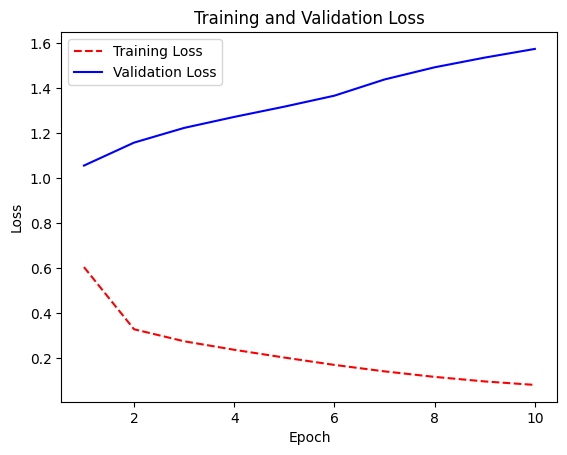

In [ ]:
import matplotlib.pyplot as plt

# Accessing loss values from the History object
training_loss = history.history['loss']
validation_loss =history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()
